<a href="https://colab.research.google.com/github/ipietri/w266_Final_Project/blob/master/notebooks/TRAC-2-notebooks/grayscaling/Trac_2_Sentiment_Greyscaling_Universal_Sentence_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

[link text](https://)# Universal Sentence Encoder


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/semantic_similarity_with_tf_hub_universal_encoder.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/semantic_similarity_with_tf_hub_universal_encoder.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/semantic_similarity_with_tf_hub_universal_encoder.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/s?q=google%2Funiversal-sentence-encoder%2F4%20OR%20google%2Funiversal-sentence-encoder-large%2F5"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

This notebook illustrates how to access the Universal Sentence Encoder and use it for sentence similarity and sentence classification tasks.

The Universal Sentence Encoder makes getting sentence level embeddings as easy as it has historically been to lookup the embeddings for individual words. The sentence embeddings can then be trivially used to compute sentence level meaning similarity as well as to enable better performance on downstream classification tasks using less supervised training data.


## Setup

This section sets up the environment for access to the Universal Sentence Encoder on TF Hub and provides examples of applying the encoder to words, sentences, and paragraphs.

In [ ]:
%%capture
!pip3 install seaborn

More detailed information about installing Tensorflow can be found at [https://www.tensorflow.org/install/](https://www.tensorflow.org/install/).

In [ ]:
#@title Load the Universal Sentence Encoder's TF Hub module
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [ ]:
#@title Compute a representation for each message, showing various lengths supported.
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
messages = [word, sentence, paragraph]

# Reduce logging output.
logging.set_verbosity(logging.ERROR)

message_embeddings = embed(messages)

for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
  print("Message: {}".format(messages[i]))
  print("Embedding size: {}".format(len(message_embedding)))
  message_embedding_snippet = ", ".join(
      (str(x) for x in message_embedding[:3]))
  print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

# Semantic Textual Similarity Task 

The embeddings produced by the Universal Sentence Encoder are approximately normalized. The semantic similarity of two sentences can be trivially computed as the inner product of the encodings.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Similarity

In [ ]:
train_df_aug = pd.read_csv('/content/drive/MyDrive/w266/grey_scaled_augmented_oversampled_subtask_a_train_data.csv')
train_df_aug['list_text'] = train_df_aug['text'].apply(lambda x: x.split())

In [162]:
train_df_aug[train_df_aug['id'] == 27]

,id,text,label,is_og
17,27,sufficient support 💪🙌 bro Keep it up 👍,NAG,0
18,27,good support 💪🙌 bro Keep it up 👍,NAG,0
19,27,wide support 💪🙌 bro Keep it up 👍,NAG,0
11993,27,Full support 💪🙌 bro \nKeep it up 👍,NAG,1


In [ ]:
import math

# get each unique id and then cycle through
unique_id_list = train_df_aug['id'].unique().tolist()

# instantiate lists 
scores_list = []
cs_list = []
mean_list = []
og_sentence = []
augmented_sentence_list = []
id_list = []

# for every origin
for id in unique_id_list: 
  # subset the dataframe and separate original and augmented examples
  data = train_df_aug[train_df_aug['id'] == id]
  og = data[data['is_og'] == 1].iloc[0].text
  og_list = data[data['is_og'] == 1].iloc[0].list_text
  
  # return all augmented examples
  augmented = data[data['is_og'] == 0]

  # if there are no augmented examples add NA to list
  if len(augmented) == 0:
    id_list.append(id)
    scores_list.append(np.nan)
    cs_list.append(np.nan)
    mean_list.append(np.nan)
    og_sentence.append(og)
    augmented_sentence_list.append(np.nan)
    

  else: 
    # encode the original example; requires list format
    sts_encode1 = tf.nn.l2_normalize(embed(tf.constant(og_list)), axis=1)
    for i in range(len(augmented)):
      example = augmented.iloc[i].text
      example_list_text = augmented.iloc[i].list_text
      # add the score for each augmented example to scores_list
      sts_encode2 = tf.nn.l2_normalize(embed(tf.constant(example_list_text)), axis=1)
      
      #cosine_similarities = tf.reduce_sum(tf.multiply(sts_encode1, sts_encode2), axis=1)
      # encode1 = embed(tf.constant(og))
      # encode2 = embed(tf.constant(example))
      m = tf.keras.metrics.CosineSimilarity(axis = 1)
      m.update_state(sts_encode1, sts_encode2)
      
      cosine_similarities = m.result().numpy()
      clip_cosine_similarities = tf.clip_by_value(cosine_similarities, -1.0, 1.0)
      scores = 1.0 - tf.acos(clip_cosine_similarities) / math.pi

      id_list.append(id)
      og_sentence.append(og)
      augmented_sentence_list.append(example)
      cs_list.append(cosine_similarities)
      scores_list.append(scores.numpy())
      
      mean_score = tf.reduce_mean(scores).numpy()
      mean_list.append(mean_score)


In [112]:
df_with_scores = pd.DataFrame({'id':id_list, 'og_sentence':og_sentence, 
              'augmented_sentence':augmented_sentence_list,
              'mean_arc_sine_score': mean_list})

df_with_scores.head()

,id,og_sentence,augmented_sentence,mean_arc_sine_score
0,3,What the fuck was this? I respect shwetabh and...,What the fuck was this? I respect shwetabh and...,0.982402
1,3,What the fuck was this? I respect shwetabh and...,What the fuck was this? I respect shwetabh and...,0.981017
2,4,Concerned authorities should bring arundathi R...,interested authorities should bring arundathi ...,0.922806
3,5,It seems like these people want to be famous n...,It seems like these people want to be known no...,0.938630
4,16,Yeah man **Fuck Bollywood** and become **matur...,Yeah man **Fuck Bollywood** and become **matur...,0.885367


In [97]:
# import pickle
# with open('/content/drive/MyDrive/w266/universal_sentence_arc_df_trac2.pkl', 'wb') as f:
#   pickle.dump(df_with_scores, f)
df_with_scores.to_csv('/content/drive/MyDrive/w266/universal_sentence_arc_df_trac2.csv', index = False)


Visualize distribution

In [115]:
mean_arc_sine_score = df_with_scores['mean_arc_sine_score'].to_list()

[Text(0.5, 1.0, 'Trac-2 Task A Mean Arc Sine Score')]

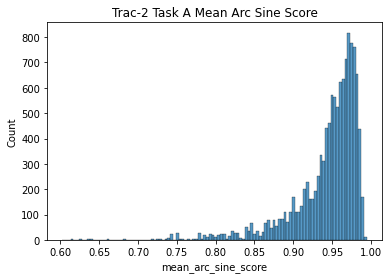

In [116]:
sns.histplot(df_with_scores['mean_arc_sine_score']).set(title='Trac-2 Task A Mean Arc Sine Score')

The data are not normally distributed. Approximately 25% of our examples have an arc sine of less than 0.98. 

In [117]:
print("P10: ", np.nanquantile(mean_arc_sine_score, 0.1))
print("P25: ", np.nanquantile(mean_arc_sine_score, 0.25))
print("P50: ", np.nanquantile(mean_arc_sine_score, 0.5))
print("P75: ", np.nanquantile(mean_arc_sine_score, 0.75))
print("P90: ", np.nanquantile(mean_arc_sine_score, 0.9))

P10:  0.8888903260231018
P25:  0.9315463304519653
P50:  0.9565186500549316
P75:  0.9723777174949646
P90:  0.9807193875312805


Low match examples

In [118]:
# standard deviation ignoring NAs
np.nanstd(df_with_scores['mean_arc_sine_score'])

0.04382219218412845

In [119]:
df_with_scores[df_with_scores['mean_arc_sine_score'] < .88]

,id,og_sentence,augmented_sentence,mean_arc_sine_score
17,27,Full support 💪🙌 bro \nKeep it up 👍,sufficient support 💪🙌 bro Keep it up 👍,0.871077
18,27,Full support 💪🙌 bro \nKeep it up 👍,good support 💪🙌 bro Keep it up 👍,0.869570
25,32,You are Right broo thanks,You are acceptable broo thanks,0.844503
26,32,You are Right broo thanks,You are okay broo thanks,0.879803
28,38,Ranu is a bad girl 👍👍😸😆😂,Ranu is a cheap girl 👍👍😸😆😂,0.873974
...,...,...,...,...
11902,10061,Shut up! \n \nBloody paid channel !,closed up! Bloody paid channel !,0.868666
11952,10115,Shut the fuck up,closed the fuck up,0.838563
11954,10118,Perfect perfect perfect answer for those m.......,better perfect perfect answer for those m........,0.879451
11955,10118,Perfect perfect perfect answer for those m.......,remarkable perfect perfect answer for those m....,0.870721


Strong Match Examples

In [158]:
strong_matches = df_with_scores[df_with_scores['mean_arc_sine_score'] > .96]


,id,og_sentence,augmented_sentence,mean_arc_sine_score
0,3,What the fuck was this? I respect shwetabh and...,What the fuck was this? I respect shwetabh and...,0.982402
1,3,What the fuck was this? I respect shwetabh and...,What the fuck was this? I respect shwetabh and...,0.981017
10,21,Why can't the Indian government take serious a...,Why can't the Indian government take serious a...,0.969110
11,21,Why can't the Indian government take serious a...,Why can't the Indian government take real acti...,0.963568
13,21,Why can't the Indian government take serious a...,Why can't the Indian government take serious a...,0.966137
...,...,...,...,...
11961,10123,Who is Arundhati roy?? Is she above constituti...,Who is Arundhati roy?? Is she above constituti...,0.960731
11962,10124,Bakwaas baate hai ye..talking about liberals a...,Bakwaas baate hai ye..talking about liberals a...,0.973178
11963,10124,Bakwaas baate hai ye..talking about liberals a...,Bakwaas baate hai ye..talking about liberals a...,0.973708
11964,10124,Bakwaas baate hai ye..talking about liberals a...,Bakwaas baate hai ye..talking about liberals a...,0.979070


# Pre-process

In [122]:
df_aug = pd.read_csv('/content/drive/MyDrive/w266/universal_sentence_arc_df_trac2.csv')

Keep all original text plus all augmented examples that meet or exceed the 25th %tile



In [174]:
augmented_examples_to_remove = df_aug[df_aug['mean_arc_sine_score']< p25_threshold]['augmented_sentence'].to_list()
task_a_train_df = train_df_aug[~train_df_aug['text'].isin(augmented_examples_to_remove)]
task_a_train_df.to_csv('/content/drive/MyDrive/w266/grey_scaled_augmented_oversampled_subtask_a_train_data_contextually_representative_ex_only.csv', index = False)


Do this again for task B

In [186]:
# add back the sentiment labels (match on id)
train_df_aug_b = pd.read_csv('/content/drive/MyDrive/w266/grey_scaled_augmented_oversampled_subtask_b_train_data.csv')
task_b_train_df = train_df_aug_b[~train_df_aug_b['text'].isin(augmented_examples_to_remove)]
task_b_train_df.to_csv('/content/drive/MyDrive/w266/grey_scaled_augmented_oversampled_subtask_b_train_data_contextually_representative_ex_only.csv', index = False)


# BERT

In [2]:
%%capture
!pip install datasets

In [3]:
%%capture
!pip install transformers

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import tensorflow as tf
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
from datasets import load_dataset

from sklearn.preprocessing import label_binarize
from sklearn import metrics

import statistics
import os

## Helper Functions

In [6]:
def from_logits_to_labels(pred, task):
    '''
    Returns labels based on predicted logits on labels [CAG,NAG,OAG] for task A. Task B is binary, and 'GEN' represents 
    the positive class.
    Parameters:
    pred: array with model prediction
    task: either 'A' or 'B'
    '''
    index_a = {0:'CAG', 1:'NAG', 2:'OAG'}
    index_b = {0:'GEN', 1:'NGEN'}
    
    if task == 'A':
        highest_prob_class = np.argmax(pred, axis=1)
        labels = np.vectorize(index_a.get)(highest_prob_class.astype(int))
        
    elif task == 'B':
        highest_prob_class = np.argmax(pred, axis=1)
        labels = np.vectorize(index_b.get)(highest_prob_class.astype(int))
    else:
        labels = []
        
    return labels  

In [7]:
def to_one_hot_labels(string_labels):
    '''
    Returns one-hot encoded labels from a multi-class label vector e.g. ['cat', 'dog', 'dog', 'lion', 'cat', ...] 
    Parameters:
    string_labels: 
    '''
    labels = pd.get_dummies(string_labels)
    labels = labels.to_numpy()
    
    return labels

In [8]:
# this is modified to get the prediction as parameter
# to avoid predicting again since inference takes time
def confusion_matrix_plot(pred_labels, true_labels, task, normalize=None):
    '''
    Returns a confusion matrix with a nice format.
    Parameters:
    pred_labels: predicted labels
    true_labels: true labels 
    task: 'A' or 'B'
    normalize: if want to normalize the confusion matrix normalize='true'
    '''
    
    # Create a confusion matrix
    cm = metrics.confusion_matrix(true_labels, pred_labels, normalize=normalize)
    cm = np.around(cm, 2)

    # Plot the confusion matrix
    if task == 'A':
        axis_labels = ['CAG', 'NAG', 'OAG']
    elif task == 'B':
        axis_labels = ['GEN', 'NGEN']

    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, cmap="Blues")

    # Create the ticks and labels
    ax.set_xticks(np.arange(len(axis_labels)))
    ax.set_yticks(np.arange(len(axis_labels)))
    ax.set_xticklabels(axis_labels)
    ax.set_yticklabels(axis_labels)

    # Axis titles
    plt.ylabel('True label', size=12)
    plt.xlabel('Predicted label', size=12)

    # Loop over data dimensions and create text annotations.
    for i in range(len(axis_labels)):
        for j in range(len(axis_labels)):
            text = ax.text(j, i, cm[i, j],ha="center", va="center", color="dimgrey", size=12)
    
    ax.set_title("Confusion Matrix", size=16, weight="bold")
    fig.tight_layout()
    plt.show()


In [9]:
def loss_accuracy_plots(training_history, xrange, task):
    '''
    Returns plots for loss and accuracy during the training process of a NN.
    Parameters:
    training_history: object that stores the training history of the NN (from model.fit(...))
    xrange: range in x axis
    task: string used for the title in the plot
    '''
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
    
    # loss plot
    ax1.plot(training_history.history['loss'], color='black')
    ax1.plot(training_history.history['val_loss'], color='blue')
    ax1.set_title('Training and validation loss Sub-Task ' + task)
    ax1.legend(['training', 'development'])
    ax1.grid(which='both')
    ax1.set_xticks(np.arange(0, xrange, 2))
    
    # accuracy plot
    ax2.plot(training_history.history['categorical_accuracy'], color='black')
    ax2.plot(training_history.history['val_categorical_accuracy'], color='blue')
    ax2.set_title('Training and validation acccuracy Sub_Task ' + task)
    ax2.legend(['training', 'development'])
    ax2.grid(which='both')
    ax2.set_xticks(np.arange(0, xrange, 2))
    plt.show()
    

## Load data
Load training, development and test datasets.

In [10]:
# Load labels using pandas dataframes

train_labels_a = pd.read_csv('/content/drive/MyDrive/w266/grey_scaled_augmented_oversampled_subtask_a_train_data_contextually_representative_ex_only.csv')['label']
train_labels_b = pd.read_csv('/content/drive/MyDrive/w266/grey_scaled_augmented_oversampled_subtask_b_train_data_contextually_representative_ex_only.csv')['label']
dev_labels_a = pd.read_csv('/content/drive/MyDrive/w266/trac2_eng_dev.csv')['Sub-task A']
dev_labels_b = pd.read_csv('/content/drive/MyDrive/w266/trac2_eng_dev.csv')['Sub-task B']
test_labels_a = pd.read_csv('/content/drive/MyDrive/w266/trac2_eng_test.csv')['Sub-task A']
test_labels_b = pd.read_csv('/content/drive/MyDrive/w266/trac2_eng_test.csv')['Sub-task B']

In [13]:
# Load text data using Hugging Face datasets
# need to use the split argument even though we are not splitting. If not, data is loaded as DatasetDict
# to load as dataset need to include the split parameter
from datasets import load_dataset, Dataset
train_dataset_a = load_dataset('csv', data_files='/content/drive/MyDrive/w266/grey_scaled_augmented_oversampled_subtask_a_train_data_contextually_representative_ex_only.csv', split = 'train[:19100]')
train_dataset_b = load_dataset('csv', data_files='/content/drive/MyDrive/w266/grey_scaled_augmented_oversampled_subtask_b_train_data_contextually_representative_ex_only.csv', split = 'train[:13665]')
dev_dataset = load_dataset('csv', data_files='/content/drive/MyDrive/w266/trac2_eng_dev.csv', split = 'train[:1066]')
test_dataset = load_dataset('csv', data_files='/content/drive/MyDrive/w266/trac2_eng_test.csv', split = 'train[:1200]')

Using custom data configuration default-ae3b764db36bfc7c


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-ae3b764db36bfc7c/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a. Subsequent calls will reuse this data.


Using custom data configuration default-0bbcb8aa22e82790


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-0bbcb8aa22e82790/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a. Subsequent calls will reuse this data.


Using custom data configuration default-a715931553fedb2f


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-a715931553fedb2f/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a. Subsequent calls will reuse this data.


Using custom data configuration default-9b0933343c54cefd


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-9b0933343c54cefd/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a. Subsequent calls will reuse this data.


## Encode labels

In [14]:
# encode labels Task A- [CAG,NAG,OAG]
train_labels_a_enc = to_one_hot_labels(train_labels_a)
dev_labels_a_enc = to_one_hot_labels(dev_labels_a)
test_labels_a_enc = to_one_hot_labels(test_labels_a)


In [15]:
# encode labels Task B- [GEN, NGEN]
train_labels_b_enc = to_one_hot_labels(train_labels_b)
dev_labels_b_enc = to_one_hot_labels(dev_labels_b)
test_labels_b_enc = to_one_hot_labels(test_labels_b)

## Prepare TensorFlow datasets for BERT

In [16]:
# remove columns to leave only the column with the posts. Column 'Text'
train_dataset_a = train_dataset_a.remove_columns(['label'])
train_dataset_b = train_dataset_b.remove_columns(['label'])
dev_dataset = dev_dataset.remove_columns(['ID', 'Sub-task A', 'Sub-task B'])
test_dataset = test_dataset.remove_columns('ID')

In [17]:
# define a BERT tokenizer
# use the bert-based-uncased tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [18]:
# tokenize the train, development and test data
# Use a max sequence of 150 tokens. Based on EDA this is enough for majority of posts

train_dataset_tok_a = train_dataset_a.map(lambda x: tokenizer(x['text'], truncation=True, padding=True, max_length=150), batched=True)
train_dataset_tok_b = train_dataset_b.map(lambda x: tokenizer(x['text'], truncation=True, padding=True, max_length=150), batched=True)
dev_dataset_tok = dev_dataset.map(lambda x: tokenizer(x['Text'], truncation=True, padding=True, max_length=150), batched=True)
test_dataset_tok = test_dataset.map(lambda x: tokenizer(x['Text'], truncation=True, padding=True, max_length=150), batched=True)

  0%|          | 0/20 [00:00<?, ?ba/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [19]:
# now we can remove the column with the original post from the dataset. We are going to use the result of tokenization for modeling
train_dataset_tok_a = train_dataset_tok_a.remove_columns(['text']).with_format('tensorflow')
train_dataset_tok_b = train_dataset_tok_b.remove_columns(['text']).with_format('tensorflow')
dev_dataset_tok = dev_dataset_tok.remove_columns(['Text']).with_format('tensorflow')
test_dataset_tok = test_dataset_tok.remove_columns(['Text']).with_format('tensorflow')

In [20]:
# extract features from tokenizer output: 'input_ids', 'token_type_ids', 'attention_mask'
train_features_a = {x: train_dataset_tok_a[x] for x in tokenizer.model_input_names}
train_features_b = {x: train_dataset_tok_b[x] for x in tokenizer.model_input_names}
dev_features = {x: dev_dataset_tok[x] for x in tokenizer.model_input_names}
test_features = {x: test_dataset_tok[x] for x in tokenizer.model_input_names}

In [21]:
# batch data

batch_size = 16
buffer_a = len(train_dataset_tok_a)
buffer_b = len(train_dataset_tok_b)

# Task A
train_tf_dataset_a = tf.data.Dataset.from_tensor_slices((train_features_a, train_labels_a_enc)).shuffle(buffer_a).batch(batch_size)
dev_tf_dataset_a = tf.data.Dataset.from_tensor_slices((dev_features, dev_labels_a_enc)).batch(batch_size)
test_tf_dataset_a = tf.data.Dataset.from_tensor_slices((test_features, test_labels_a_enc)).batch(batch_size)

# Task B
train_tf_dataset_b = tf.data.Dataset.from_tensor_slices((train_features_b, train_labels_b_enc)).shuffle(buffer_b).batch(batch_size)
dev_tf_dataset_b = tf.data.Dataset.from_tensor_slices((dev_features, dev_labels_b_enc)).batch(batch_size)
test_tf_dataset_b = tf.data.Dataset.from_tensor_slices((test_features, test_labels_b_enc)).batch(batch_size)

## Model Task A

In [22]:
import matplotlib.pyplot as plt
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import tensorflow as tf

from transformers import TFAutoModelForSequenceClassification
from datasets import load_dataset

from sklearn.preprocessing import label_binarize
from sklearn import metrics

import statistics

In [ ]:
# initialize lists to keep statistics of all runs
f1_NAG = []
f1_CAG = []
f1_OAG = []
f1_macro = []
f1_weighted = []
accuracy = []

# run 15 times the model to get an idea of variability
for i in range(5):

  # delete model if exists
  try:
    del BERT_model_A
  except:
    pass
  
  # define the model. Task A is a classification task with 3 labels
  BERT_model_A = TFAutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

  # compile model
  BERT_model_A.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                       loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                       metrics=tf.metrics.CategoricalAccuracy()
                       )
  # fit model
  training_history = BERT_model_A.fit(train_tf_dataset_a, validation_data=dev_tf_dataset_a, epochs=2)

  print(f'---------------------------Iteration {i} ---------------------------\n')
  # Evaluate model on TEST data
  # predict using model. Returns logits
  pred_labels_test = BERT_model_A.predict(test_features)[0]
  # convert logits lo labels
  pred_labels_test = from_logits_to_labels(pred_labels_test, 'A')

  # get f1-score for all classes, macro and weighted
  x = metrics.classification_report(test_labels_a, pred_labels_test, digits=3, output_dict=True)
  # append values to keep scores
  f1_NAG.append(x['NAG']['f1-score'])
  f1_CAG.append(x['CAG']['f1-score'])
  f1_OAG.append(x['OAG']['f1-score'])
  f1_macro.append(x['macro avg']['f1-score'])
  f1_weighted.append(x['weighted avg']['f1-score'])
  accuracy.append(x['accuracy'])

# calculate mean
f1_NAG_mean = round(statistics.mean(f1_NAG), 3)
f1_CAG_mean = round(statistics.mean(f1_CAG), 3)
f1_OAG_mean = round(statistics.mean(f1_OAG), 3)
f1_macro_mean = round(statistics.mean(f1_macro), 3)
f1_weighted_mean = round(statistics.mean(f1_weighted), 3)
accuracy_mean = round(statistics.mean(accuracy), 3)

# calculate standard deviation
f1_NAG_std = round(statistics.stdev(f1_NAG), 3)
f1_CAG_std = round(statistics.stdev(f1_CAG), 3)
f1_OAG_std = round(statistics.stdev(f1_OAG), 3)
f1_macro_std = round(statistics.stdev(f1_macro), 3)
f1_weighted_std = round(statistics.stdev(f1_weighted), 3)
accuracy_std = round(statistics.stdev(accuracy), 3)

print('Class NAG')
print(f'Mean f1-score = {f1_NAG_mean}')
print(f'Standard deviation f1-score = {f1_NAG_std}\n')

print('Class CAG')
print(f'Mean f1-score = {f1_CAG_mean}')
print(f'Standard deviation f1-score = {f1_CAG_std}\n')

print('Class OAG')
print(f'Mean f1-score = {f1_OAG_mean}')
print(f'Standard deviation f1-score = {f1_OAG_std}\n')

print('Class Macro')
print(f'Mean f1-score = {f1_macro_mean}')
print(f'Standard deviation f1-score = {f1_macro_std}\n')

print('Class Weighted')
print(f'Mean f1-score = {f1_weighted_mean}')
print(f'Standard deviation f1-score = {f1_weighted_std}\n')

print('Accuracy')
print(f'Mean = {accuracy_mean}')
print(f'Standard deviation = {accuracy_std}\n')

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
1194/1194 [==============================] - 246s 189ms/step - loss: 0.2783 - categorical_accuracy: 0.8934 - val_loss: 0.7601 - val_categorical_accuracy: 0.7805
Epoch 2/2
1194/1194 [==============================] - 222s 186ms/step - loss: 0.0561 - categorical_accuracy: 0.9827 - val_loss: 0.8589 - val_categorical_accuracy: 0.7983
---------------------------Iteration 0 ---------------------------



All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
 944/1194 [======================>.......] - ETA: 45s - loss: 0.3135 - categorical_accuracy: 0.8765

## Model Task B

In [ ]:
# initialize lists to keep statistics of all runs
f1_NGEN = []
f1_GEN = []
f1_macro_b = []
f1_weighted_b = []
accuracy_b = []

for i in range(5):

  # delete model if exists
  try:
    del BERT_model_B
  except:
    pass
  
  # define the model. Task B is a classification task with 2 labels
  BERT_model_B = TFAutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

  # compile model
  BERT_model_B.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                       loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                       metrics=tf.metrics.CategoricalAccuracy()
                       )
  
  # fit model
  training_history = BERT_model_B.fit(train_tf_dataset_b, validation_data=dev_tf_dataset_b, epochs=3)

  print(f'---------------------------Iteration {i} ---------------------------\n')
  # Evaluate model on TEST data
  # predict using model. Returns logits
  pred_labels_test = BERT_model_B.predict(test_features)[0]

  # convert logits lo labels
  pred_labels_test = from_logits_to_labels(pred_labels_test, 'B')

  # get f1-score for all classes, macro and weighted
  x = metrics.classification_report(test_labels_b, pred_labels_test, digits=3, output_dict=True)
  # append values to keep scores
  f1_NGEN.append(x['NGEN']['f1-score'])
  f1_GEN.append(x['GEN']['f1-score'])
  f1_macro_b.append(x['macro avg']['f1-score'])
  f1_weighted_b.append(x['weighted avg']['f1-score'])
  accuracy_b.append(x['accuracy'])

# calculate mean
f1_NGEN_mean = round(statistics.mean(f1_NGEN), 3)
f1_GEN_mean = round(statistics.mean(f1_GEN), 3)
f1_macro_b_mean = round(statistics.mean(f1_macro_b), 3)
f1_weighted_b_mean = round(statistics.mean(f1_weighted_b), 3)
accuracy_b_mean = round(statistics.mean(accuracy_b), 3)

# calculate standard deviation
f1_NGEN_std = round(statistics.stdev(f1_NGEN), 3)
f1_GEN_std = round(statistics.stdev(f1_GEN), 3)
f1_macro_b_std = round(statistics.stdev(f1_macro_b), 3)
f1_weighted_b_std = round(statistics.stdev(f1_weighted_b), 3)
accuracy_b_std = round(statistics.stdev(accuracy_b), 3)

print('Class NGEN')
print(f'Mean f1-score = {f1_NGEN_mean}')
print(f'Standard deviation f1-score = {f1_NGEN_std}\n')

print('Class GEN')
print(f'Mean f1-score = {f1_GEN_mean}')
print(f'Standard deviation f1-score = {f1_GEN_std}\n')

print('Macro')
print(f'Mean f1-score = {f1_macro_b_mean}')
print(f'Standard deviation f1-score = {f1_macro_b_std}\n')

print('Weighted')
print(f'Mean f1-score = {f1_weighted_b_mean}')
print(f'Standard deviation f1-score = {f1_weighted_b_std}\n')

print('Accuracy')
print(f'Mean = {accuracy_b_mean}')
print(f'Standard deviation = {accuracy_b_std}\n')
